# Loading Data
We have already seen how to load a dataset provided by the Pytorch library, but what about custom data?

Here we will focus on datasets composed by images.

## Labeled Dataset
Dataset comes in the following form: 
- Main_Folder
    - label0
    - label1
    - ...

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
# Firstly define the transforms that you want to apply to the data
data_transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor()])

In [3]:
# Use ImageFolder as data loader
# It will iterate in the root folder and find all the subfolders that define the labels
cats_dogs_ds = datasets.ImageFolder(
            root='res/custom_dataset/two_class_dataset',
            transform=data_transform) #apply transform when loading data

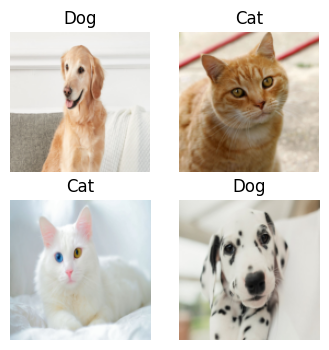

In [4]:
# Visualize the data
import matplotlib.pyplot as plt

to_pil = transforms.ToPILImage()

labels_map = {
    0: "Cat",
    1: "Dog"
}
figure = plt.figure(figsize=(4, 4))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    # select a random index
    sample_idx = torch.randint(len(cats_dogs_ds), size=(1,)).item()
    # get the corresponding tuple (img, label) from the dataset
    img, label = cats_dogs_ds[sample_idx]
    # plot the data
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(to_pil(img))
plt.show()

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity.

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(cats_dogs_ds, # dataset to iterate
                              batch_size=2, # how many images to load every iteration
                              shuffle=True) # sample data randomly

In [8]:
# iterate trough the dataloader
for epoch in range(2):
    print("Epoch: {}".format(epoch))
    for i, (img, labels) in enumerate(train_dataloader):
        print("Loaded images of size {} with labels {}".format(img.size(), labels))
        #training...

print("--------")
# Iterate only once
img, labels = next(iter(train_dataloader))
print("Loaded images of size {} with labels {}".format(img.size(), labels))

Epoch: 0
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 0])
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 1])
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([1, 1])
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([1, 0])
Epoch: 1
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 1])
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 0])
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([1, 1])
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 1])
--------
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 1])


## Unlabeled Dataset
Images are in a folder and do not have a particular label.

In [9]:
# Use Custom Dataset
from PIL import Image
from torch.utils.data import Dataset

# Define a function to load images
def pil_loader(path):
    # open path as file to avoid ResourceWarning
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
# Alternative: from torchvision.io import read_image

In [10]:
import glob

class PaintingDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.file_list = glob.glob(self.root_dir + "*.jpg") # we want only jpg images

    def __len__(self):
        return len(self.file_list)
    
    # This function is called every time we iterate the dataset
    def __getitem__(self, idx):
        
        img_name = self.file_list[idx]
        image = pil_loader(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [11]:
# Create the dataset
paint_ds = PaintingDataset(
            root_dir='res/custom_dataset/unlabeled_dataset/friedrich_paintings/',
            transform=data_transform)
print(len(paint_ds))

4


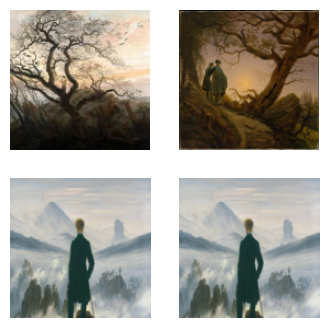

In [12]:
# Visualize the data
figure = plt.figure(figsize=(4, 4))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(paint_ds), size=(1,)).item()
    img = paint_ds[sample_idx] # __get_item__() method is called
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(to_pil(img))
plt.show()

In [13]:
# You can then iterate the dataset using a DataLoader as before
paint_dataloader = DataLoader(paint_ds, # dataset to iterate
                              batch_size=2, # how many images to load every iteration
                              shuffle=True) # sample data randomly

for i, (img) in enumerate(paint_dataloader):
    print("Loaded images of size {}".format(img.size()))

Loaded images of size torch.Size([2, 3, 128, 128])
Loaded images of size torch.Size([2, 3, 128, 128])


## Custom Dataset are much more than that
You can write custom dataset to load dataset that comes with additional information (like keypoints, text, etc...)

### Example: Loading Semantic Masks
We want to load image of human faces and the corresponding semantic mask that segment the different parts in the human face (nose, eyes, mouth, etc...)

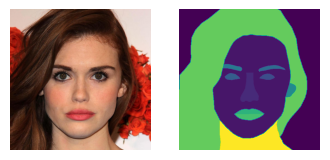

In [14]:
# Show the data
img = Image.open('res/custom_dataset/semantic_masks/img/0.jpg')
# Show the data
mask = Image.open('res/custom_dataset/semantic_masks/mask/0.png')

figure = plt.figure(figsize=(4, 4))
cols, rows = 2, 1
figure.add_subplot(rows, cols, 1)
plt.imshow(img)
plt.axis("off")
figure.add_subplot(rows, cols, 2)
plt.imshow(mask)
plt.axis("off")
plt.show()

In [15]:
import os

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP', '.tiff', '.webp'
]
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

class ImgMaskDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform, mask_transform):
        
        # get the files list
        self.image_paths = self.get_paths(img_dir)
        self.mask_paths = self.get_paths(mask_dir)
        
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        size = len(self.image_paths)
        self.dataset_size = size

    def get_paths(self, dir):
        images = []
        for root, dnames, fnames in sorted(os.walk(dir)):
            for fname in fnames:
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    images.append(path)
        return images

    def __getitem__(self, index):

        # Label Image
        label_path = self.mask_paths[index]
        label = Image.open(label_path)

        label_tensor = self.mask_transform(label) * 255.0 # mask goes from 0 to 19
        
        # input image (real images)
        image_path = self.image_paths[index]
        image = pil_loader(image_path)
        
        image_tensor = self.img_transform(image)

        input_dict = {'label': label_tensor,
                      'image': image_tensor,
                      'img_path': image_path,
                      'label_path': label_path,
                      }

        return input_dict
    
    def __len__(self):
        return self.dataset_size

In [16]:
# Inizialize dataset
img_transform = transforms.Compose([transforms.Resize((128,128)), # Why no Random Horizontal Flip?
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])

mask_transform = transforms.Compose([transforms.Resize((128,128)),
                                    transforms.ToTensor()])

img_dir = 'res/custom_dataset/semantic_masks/img/'
mask_dir = 'res/custom_dataset/semantic_masks/mask/'

img_mask_ds = ImgMaskDataset(img_dir = img_dir, mask_dir = mask_dir, img_transform = img_transform,
                             mask_transform = mask_transform)
print(len(img_mask_ds))

4


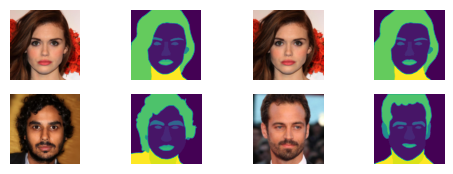

In [18]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)   

figure = plt.figure(figsize=(6, 2))
cols, rows = 4, 2
for i in range(1, cols * rows + 1, 2):
    sample_idx = torch.randint(len(img_mask_ds), size=(1,)).item()
    data = img_mask_ds[sample_idx] # __get_item__() method is called
    
    img = data['image']
    label = data['label']
    
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(to_pil(denorm(img)))
    
    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    plt.imshow(to_pil(label/255))
           
plt.show()

In [ ]:
# ex1: the folder with path res\custom_dataset\attributes_dataset contains: 
# - a txt file containing face attributes
# - a folder "images" containing face images
# the attribute files is organized as follows: first line is the number of images in the folder "images",
# second line is a list of attributes names and all the remaining lines describe which attributes 
# each image has with the following notation ('1' = attribute is present, '-1' = attribute is not present).
# Create a custom dataset that, when __get_item()__ is called, returns:
# 1) the image data
# 2) the attributes of that image organized as a tensor of 1 and 0 values (1 = attribute is present
# , 0 = attribute is not present). Example: 1.,1.,0.,0.,...,1.,0.,1.


In [ ]:
# ex2: modify the dataset class in order to return only a subset of attributes defined by an array
# like ["Blond_Hair", "Heavy_Makeup", "Male", "Young"]